## Setup

In [1]:
!pip install optuna lightgbm requests rdata scikit-learn ipywidgets matplotlib

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 5.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 9.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 7.0 MB/s eta 0:00:0000:0100:01
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.6/607.6 kB 7.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 10.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
import pandas as pd
from lightgbm import LGBMClassifier                                                                                                                                                                                                                                                                                                                                                             
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import optuna

import rdata
import requests
import io

## Download data

In [2]:
url = "https://github.com/dutangc/CASdatasets/raw/refs/heads/master/data/pg15training.rda"
output_directory = "../data/"
file_name = "pg15training.csv"

# Download the file from the URL
response = requests.get(url)

# Write the content to a file
f = io.BytesIO(response.content)
r_data = rdata.read_rda(f)['pg15training']
r_data.to_csv(output_directory + file_name, index=False)

## Load Data

In [2]:
data = pd.read_csv("../data/pg15training.csv")
data.head()

,PolNum,CalYear,Gender,Type,Category,Occupation,Age,Group1,Bonus,Poldur,Value,Adind,SubGroup2,Group2,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
0,200114978,2009,Male,C,Large,Employed,25,18,90,3,15080,0,L46,L,72.012883,365,1,0,0.0,0.0
1,200114994,2009,Male,E,Large,Employed,20,11,30,2,22370,1,O38,O,39.550411,365,1,0,0.0,0.0
2,200115001,2009,Female,E,Large,Unemployed,42,11,150,0,39650,0,Q28,Q,169.529148,365,2,0,0.0,0.0
3,200115011,2009,Female,C,Medium,Housewife,21,5,0,0,12600,1,L6,L,58.894688,365,1,0,0.0,0.0
4,200115015,2009,Female,D,Large,Employed,33,12,30,10,9065,0,N4,N,109.631885,365,2,0,0.0,0.0


In [3]:
data.Numtppd.value_counts()

Numtppd
0    87744
1    10358
2     1518
3      306
4       62
5       17
6        9
7        7
Name: count, dtype: int64

## Prep data

In [4]:
# Create the target column
data['target'] = data['Numtppd'].apply(lambda x: 1 if x != 0 else 0)

# Drop some columns
data = data.drop(columns=["Numtppd", "Numtpbi", "Indtppd", "Indtpbi"])

# Add one hot encoder processor
categorical_columns = ['CalYear', 'Gender', 'Type', 'Category', 'Occupation', 'SubGroup2', 'Group2', 'Group1']
data = pd.get_dummies(data, columns=categorical_columns)

In [5]:
data.head()

,PolNum,Age,Bonus,Poldur,Value,Adind,Density,Exppdays,target,CalYear_2009,...,Group1_11,Group1_12,Group1_13,Group1_14,Group1_15,Group1_16,Group1_17,Group1_18,Group1_19,Group1_20
0,200114978,25,90,3,15080,0,72.012883,365,1,True,...,False,False,False,False,False,False,False,True,False,False
1,200114994,20,30,2,22370,1,39.550411,365,1,True,...,True,False,False,False,False,False,False,False,False,False
2,200115001,42,150,0,39650,0,169.529148,365,1,True,...,True,False,False,False,False,False,False,False,False,False
3,200115011,21,0,0,12600,1,58.894688,365,1,True,...,False,False,False,False,False,False,False,False,False,False
4,200115015,33,30,10,9065,0,109.631885,365,1,True,...,False,True,False,False,False,False,False,False,False,False


## Split data

In [6]:
X = data.drop("target", axis=1)
y = data['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
print(X.columns)

Index(['PolNum', 'Age', 'Bonus', 'Poldur', 'Value', 'Adind', 'Density',
       'Exppdays', 'CalYear_2009', 'CalYear_2010',
       ...
       'Group1_11', 'Group1_12', 'Group1_13', 'Group1_14', 'Group1_15',
       'Group1_16', 'Group1_17', 'Group1_18', 'Group1_19', 'Group1_20'],
      dtype='object', length=527)


## Train model

In [8]:
def objective(trial, X_train, y_train):
    # Split the data into training and validation sets
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    # Define the hyperparameter search space
    # Optuna will choose values in this search space such that the search is the most efficient
    param = {
        'objective': 'binary',
        'n_jobs' : -1,
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }
    
    # Initialize the model with the chosen set of hyperparameters
    model = LGBMClassifier(**param, verbosity=-1)
    
    # Train the model
    model.fit(X_train_sub, y_train_sub)
    
    # Make predictions on the validation set
    y_pred = model.predict(X_val)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    
    return accuracy

# Setting the logging level WARNING, the INFO logs are suppressed.
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=20, show_progress_bar=True)

# Retrieve the best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

# Train the final model with the best hyperparameters
best_model = LGBMClassifier(**best_params)
best_model.fit(X_train, y_train)

  0%|          | 0/20 [00:00<?, ?it/s]

Best hyperparameters:  {'n_estimators': 148, 'learning_rate': 0.05664256476347034, 'max_depth': 7, 'num_leaves': 72, 'min_child_samples': 10, 'subsample': 0.6152153278573371, 'colsample_bytree': 0.9585980970783512}


LGBMClassifier(colsample_bytree=0.9585980970783512,
               learning_rate=0.05664256476347034, max_depth=7,
               min_child_samples=10, n_estimators=148, num_leaves=72,
               subsample=0.6152153278573371)

## Evaluate model

In [12]:
print(type(pd.Series(y_test)))
print(type(y_test))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


Accuracy: 0.8760809797550613
Precision: 0.6283987915407855
Recall: 0.0811232449297972
F1 Score: 0.14369602763385148


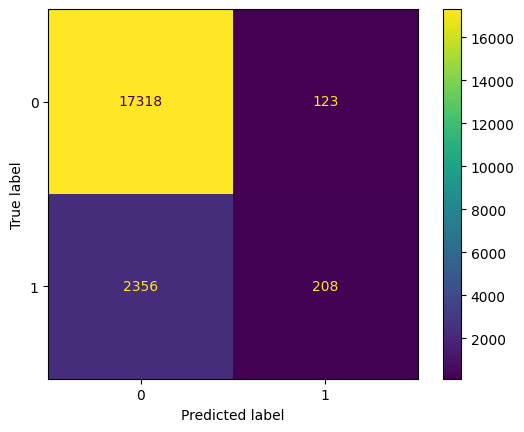

In [14]:
# Make predictions
y_pred = best_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, pd.Series(y_pred))
precision = precision_score(y_test, pd.Series(y_pred))
recall = recall_score(y_test, pd.Series(y_pred))
f1 = f1_score(y_test, pd.Series(y_pred))
cm = ConfusionMatrixDisplay.from_predictions(y_test, pd.Series(y_pred))

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")